# Analysis of Phillips phantom

This analysis very closely follows the MrGoam analysis notebook, where I provide a fair bit of detail about what is going on - I suggest you read that one first so you understand the following steps! 

## Marker Extraction

One challenge with this phantom is that the markers don't have unique contrast on the CT. We were unable to easily extract the marker positions from the CT image, so instead we create an 'artificial' ground truth based on the knwon marker positions. This isn't ideal to be honest, but it does look like a pretty precise build so it's probably fine.

[MarkerAnalysis.py: line 123  WARNING] MR data file dicom_data.json not found at C:\Users\Brendan\Documents\temp\genesis_analysis\_segmentation_data\PhilipPhantom_MRI\2022-08__Studies\GOAM^ImageX_ZZZIMAGEX_MR_2022-08-31_172341_._T2.3D.Tra.2min_n401__00002. Continuing


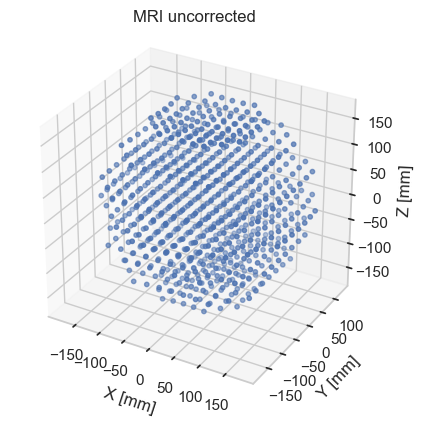

[MarkerAnalysis.py: line 129  WARNING] numpy input is deprecated, please use pandas input with ['x', 'y', 'z'] cols instead


In [16]:
import sys
import os
sys.path.insert(0, '../python_codes')
from pathlib import Path
from mri_distortion_toolkit.MarkerAnalysis import MarkerVolume,MatchedMarkerVolumes
from python_codes.philips_phantom import philips_phantom
from mri_distortion_toolkit.utilities import plot_distortion_xyz_hist

this_file_loc = Path(os.path.abspath(''))
data_loc = this_file_loc.parent / '_segmentation_data'

# Distorted centroids corrected
philips_MR_corrected = MarkerVolume(data_loc / 'PhilipPhantom_MRI' / '2022-08__Studies\GOAM^ImageX_ZZZIMAGEX_MR_2022-08-31_172341_._T2.3D.Tra.2min_n401__00002' / 'slicer_centroids.mrk.json')
(x, y, z) = philips_phantom.get_alignment_coords(philips_MR_corrected)
# philips_MR_corrected.MarkerCentroids = philips_MR_corrected.MarkerCentroids[philips_MR_corrected.MarkerCentroids['r'] < 190]
# philips_MR_corrected.plot_3D_markers(title='MRI')

# Distorted Centroids uncorrected
philips_MR_uncorrected = MarkerVolume(data_loc / 'PhilipPhantom_MRI' / '2022-08__Studies\GOAM^ImageX_ZZZIMAGEX_MR_2022-08-31_172341_._T2.3D.Tra.2min_n401__00000' / 'slicer_centroids.mrk.json')
philips_MR_uncorrected.plot_3D_markers(title='MRI uncorrected')

# Undistorted centroids
philips_centroids = philips_phantom.generate_centroids(x, y, z)
philips_gt = MarkerVolume(philips_centroids)


## Match Markers with distortion correction

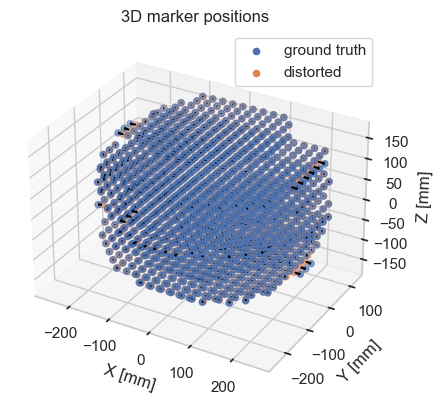

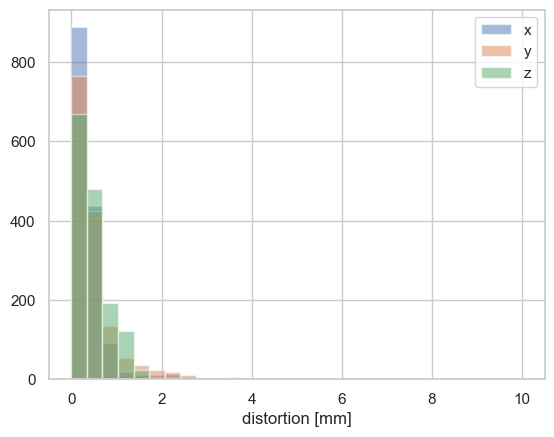

In [17]:
# # Match markers corrected
corrected = MatchedMarkerVolumes(philips_gt, philips_MR_corrected)
corrected.plot_3D_markers()
plot_distortion_xyz_hist(corrected)


Now that these 'markers' on the edge are actually the result of phase wrapping artefacts. So the largest distortion we are seeing here are not real. We may be able to get rid of these artefacts by using a larger FOV, but for now we will get rid of them by just clipping the input data:

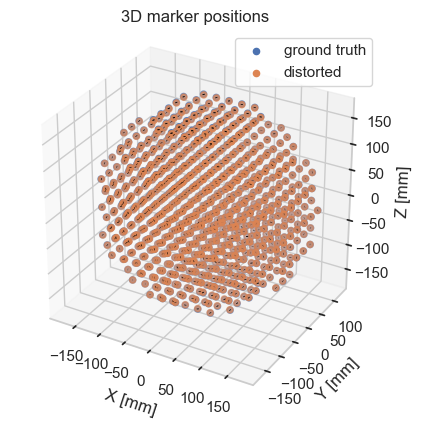

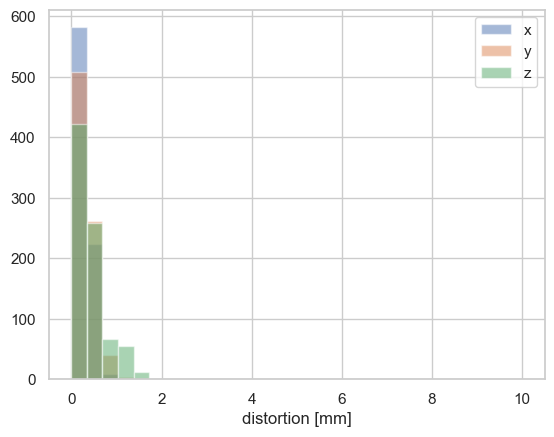

In [18]:
philips_MR_corrected.MarkerCentroids = philips_MR_corrected.MarkerCentroids[philips_MR_corrected.MarkerCentroids['r'] < 190]
corrected = MatchedMarkerVolumes(philips_gt, philips_MR_corrected)
corrected.plot_3D_markers()
plot_distortion_xyz_hist(corrected)

OK, once we've clipped the data to a total volume of 380 mm (still a very large FOV by our standards) all distortion is comfortably within 2 mm. Let's take a look at the result without distortion correction. Again, we will first filter the markers because otherwise we have phase wrap and marker overlap and it becomes impossible to perform a 1:1 match.



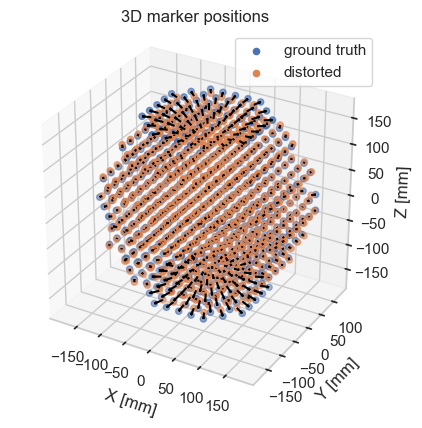

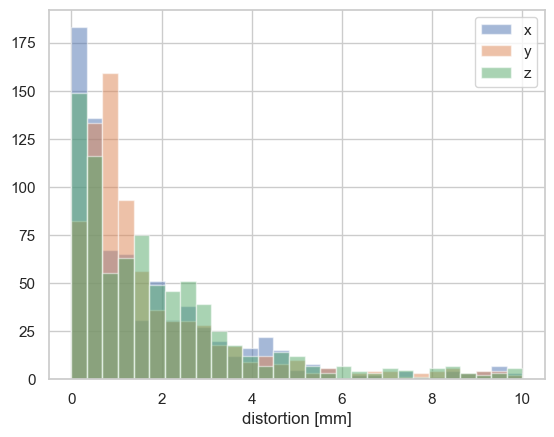

In [19]:
# trim data:
philips_MR_uncorrected.MarkerCentroids = philips_MR_uncorrected.MarkerCentroids[philips_MR_uncorrected.MarkerCentroids['r'] < 190]
# match  data:
uncorrected = MatchedMarkerVolumes(philips_gt, philips_MR_uncorrected)
uncorrected.plot_3D_markers()
plot_distortion_xyz_hist(uncorrected)


We can also print ourselves out a little report:

In [20]:
print(f'Median distortion: {uncorrected.MatchedCentroids.match_distance.median(): 1.1f} mm, '
      f'Max distortion: {uncorrected.MatchedCentroids.match_distance.max(): 1.1f} mm')

Median distortion:  3.2 mm, Max distortion:  18.1 mm


So a maximum distortion of 18.1 over 380 mm - honestly it's pretty impressive. The distortion correction is even more impressive - good job Phillips! 

From here, we could go on to fit spherical harmonics and attempt our own distortion correction algorithm, but I guess that's not that interesting to you (plus as demonstrated in the mr Goam notebook we have to iron out some kinks for it, not that I'm trying to kink shame anyone).

What I might do from here is demonstrate the generation of reports. 

## Reporting - data driven

We can do this either using the data directly, or by first fitting harmonics and reconstructing the reporting data. The latter makes prettier figures, but you'd probably feel more confident using the data directly so we will do that. first I will start with the corrected data. 

In addition, I am importing the Elekta_Distortion_tests. Users can also [write their own test suite](https://acrf-image-x-institute.github.io/mri_distortion_toolkit/reporting.html).

In [ ]:
from mri_distortion_toolkit.Reports import MRI_QA_Reporter
from mri_distortion_toolkit.Reports import Elekta_Distortion_tests

report = MRI_QA_Reporter(MatchedMarkerVolume=corrected.MatchedCentroids,
                         r_outer=190,
                         dicom_data=philips_MR_uncorrected.dicom_data,
                         tests_to_run=Elekta_Distortion_tests)
report.write_html_report()

I haven't figured out an elegant way to share these reports yet so I will just email them to you seperately. If we were to implement this properly they would be hosted in a server somewhere...

## Reporting - harmonic driven

The problem with the marker data is that it's relatively sparse, especially when it comes to generating pretty plots. Instead we can use harmonics to reconstruct data wherever we want. Of course, the two cases **should** produce very similar reults!

In [21]:
from mri_distortion_toolkit.FieldCalculation import ConvertMatchedMarkersToBz
from mri_distortion_toolkit import calculate_harmonics

Bz = ConvertMatchedMarkersToBz(corrected.MatchedCentroids, philips_MR_uncorrected.dicom_data)
# gradient_strength = np.array(dicom_data['gradient_strength'])
# normalisation_factor = [1 / gradient_strength[0], 1 / gradient_strength[1], 1 / gradient_strength[2],
#                         1]  # this normalised gradient harmonics to 1mT/m
G_x_Harmonics, G_y_Harmonics, G_z_Harmonics, B0_Harmonics = calculate_harmonics(Bz.MagneticFields,
                                                                                n_order=5,
                                                                                norm=None)

Initial pk-pk:        3.996e+06 μT
Reconstructed pk-pk:  3.994e+06 μT
Residual pk-pk:       1.007e+04 μT ( 0.3%)
Initial pk-pk:        2.678e+06 μT
Reconstructed pk-pk:  2.677e+06 μT
Residual pk-pk:       9.049e+03 μT ( 0.3%)
Initial pk-pk:        3.754e+06 μT
Reconstructed pk-pk:  3.751e+06 μT
Residual pk-pk:       1.831e+04 μT ( 0.5%)


Note the very low fit errors in each case; that is what we want to see

In [22]:
from mri_distortion_toolkit.Reports import MRI_QA_Reporter
report_harmonics = MRI_QA_Reporter(gradient_harmonics=[G_x_Harmonics, G_y_Harmonics, G_z_Harmonics],
                         r_outer=190,
                         dicom_data=philips_MR_uncorrected.dicom_data,
                         tests_to_run=Elekta_Distortion_tests)
report_harmonics.write_html_report()

NameError: name 'MRI_QA_Reporter' is not defined

In [ ]:
I